# Praca domowa z ML numer 8.

<a href="https://colab.research.google.com/github/tomczj/ML24_25/blob/main/Gradient_training/homework_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Uwaga: w połowie pliku znajduje się linijka, która zapobiega odpaleniu się reszty kodu. Została ona wprowadzona, ponieważ bardzo długo się liczło, a animacje i tak zawarto w poniższym pliku (pozostały kod generuje te animacje).

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time

## Analiza zbieżności w zależności od funkcji straty

Funkcja do rysowania trajektorii pochodząca z zajęć


In [2]:
# Ustawienie ziarna losowości dla powtarzalnych wyników
torch.manual_seed(42)
np.random.seed(42)

# Parametry elipsy: dwa ogniska oraz stała suma odległości 
focus1 = torch.tensor([-2.0, 0.0])  # pierwsze ognisko elipsy
focus2 = torch.tensor([2.0, 0.0])   # drugie ognisko elipsy
constant_sum = 6.0                  # stała suma odległości od ognisk

# Inicjalizacja losowych punktów 2D w przedziale [-5, 5]
num_points = 100
points = torch.rand((num_points, 2)) * 10 - 5  # równomierny rozkład w kwadracie
points.requires_grad = True                     # włączenie śledzenia gradientów w PyTorch


def plot_results(epoch, trajectories, loss_history=None):
    # 1) Przygotowanie obszarów rysowania: jeden wykres lub dwa (z wykresem strat)
    if loss_history is not None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # dwa wykresy obok siebie
    else:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))    # tylko jeden wykres
        axes = [ax]

    # 2) Pobranie najnowszych pozycji punktów z listy trajektorii
    #    trajectories[i][-1] to pozycja punktu i w bieżącej epoce
    points_arr = np.array([trajectories[i][-1] for i in range(num_points)])

    # 3) Lewy wykres: punkty i ogniska elipsy
    axes[0].scatter(
        points_arr[:, 0], points_arr[:, 1],
        label=f'Points - Epoch {epoch}', s=10, alpha=0.7
    )
    # Konwersja ognisk do numpy, jeśli były w torch.Tensor
    f1 = focus1.detach().cpu().numpy()
    f2 = focus2.detach().cpu().numpy()
    axes[0].scatter(
        [f1[0], f2[0]], [f1[1], f2[1]],
        color='red', marker='x', s=100, label='Foci'
    )

    # 4) Rysowanie tras ruchu (trajectory) dla każdego punktu
    for traj in trajectories:
        traj_np = np.array(traj)
        axes[0].plot(
            traj_np[:, 0], traj_np[:, 1],
            color='gray', linestyle='-', linewidth=0.5, alpha=0.5
        )

    # 5) Ustawienia osi, legendy i siatki
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].legend()
    axes[0].grid(True)

    # 6) Tytuł lewego wykresu zależnie od tego, czy podano historię strat
    if loss_history is not None:
        axes[0].set_title(f'Points after Epoch {epoch}')

        # 7) Prawy wykres: przebieg wartości funkcji strat
        axes[1].plot(
            loss_history, color='blue', linewidth=2
        )
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].set_title('Loss Convergence')
        axes[1].grid(True)
    else:
        axes[0].set_title(f'Points before Epoch {epoch}')

    # 8) Wyświetlenie
    plt.tight_layout()
    plt.show()

#### Funkcja straty $l_0$

W przypadku tej funkcji straty nie udało mi się jej zaimplementować w sposób umożliwiający poprawne działanie kodu. Niemniej jednak warto zastanowić się, czy nawet przy poprawnej implementacji moglibyśmy oczekiwać jakiejkolwiek sensownej zbieżności w trakcie uczenia. Zauważmy, że składnik
$$\mathbf{1}(\epsilon_i \neq 0)$$
jest funkcją nieróżniczkowalną w zerze, a poza zerem jej gradient wynosi $[0, 0]$. W efekcie, niezależnie od wartości błędów $\epsilon_i$, gradient w każdym punkcie (poza nieskończenie małym otoczeniem zera) wynosi zero. Oznacza to, że nasz algorytm oparty na Gradient Boostingu nie będzie wykonywał żadnych aktualizacji — staniemy w miejscu już po pierwszym kroku. Trening nie będzie więc postępował, a punkty nie będą przesuwały się w stronę elipsy.

#### Funkcja straty $l_1$ - kod pochodzący z zajęć z drobnymi modyfkiacjami

Using device: cuda


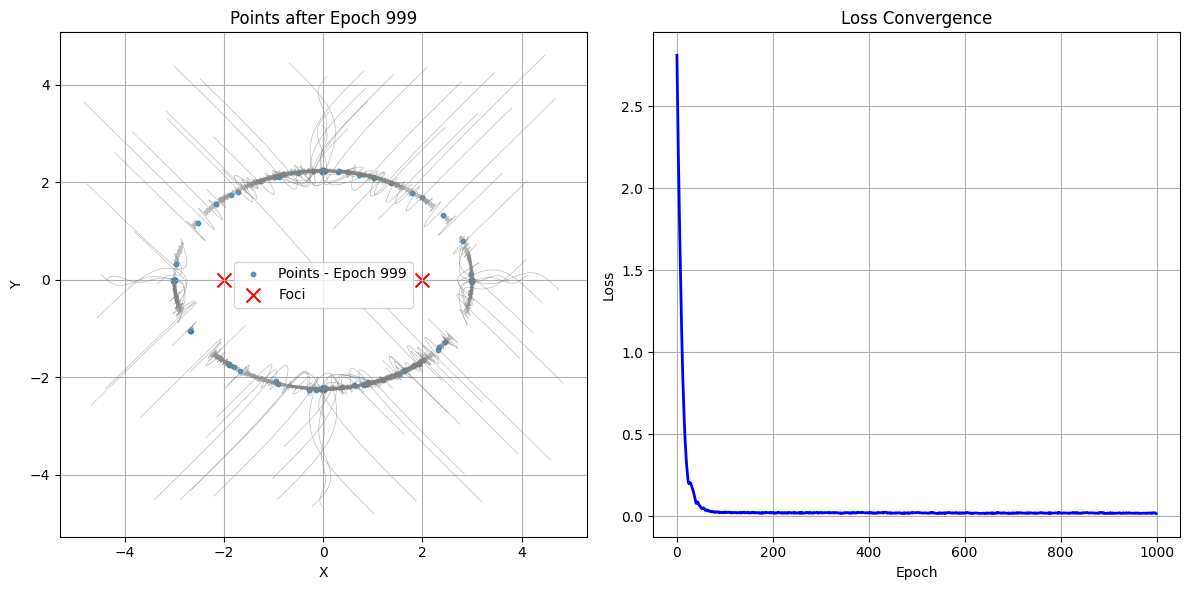

Elapsed time: 1.55 s


In [3]:
# 1) Wybór urządzenia: GPU jeśli dostępne, inaczej CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ustawienie ziarna dla powtarzalności
torch.manual_seed(42)
np.random.seed(42)

# 2) Parametry elipsy – przenosimy od razu na wybrane urządzenie
focus1 = torch.tensor([-2.0, 0.0], device=device)  # pierwsze ognisko
focus2 = torch.tensor([2.0, 0.0],  device=device)  # drugie ognisko
constant_sum = 6.0

# 3) Inicjalizacja punktów na urządzeniu
num_points = 100
points = torch.rand((num_points, 2), device=device) * 10 - 5
points.requires_grad = True

# Reset trajektorii i historii strat
trajectories = [[] for _ in range(num_points)]
loss_history = []

# 4) Definicja optymalizatora – wskazujemy, że optymalizujemy 'points' na GPU/CPU
optimizer = torch.optim.Adam([points], lr=0.1)

# Pomocnicze do mierzenia czasu
start_time = time.time()

# Parametry treningu
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # 5) Obliczenia na GPU: dystanse do ognisk
    dist1 = torch.norm(points - focus1, dim=1)
    dist2 = torch.norm(points - focus2, dim=1)

    loss = torch.mean(torch.abs(dist1 + dist2 - constant_sum))

    loss.backward()
    optimizer.step()

    # 6) Zapis straty
    loss_history.append(loss.item())

    # 7) Przechowanie pozycji dla wizualizacji 
    pts_cpu = points.detach().cpu().numpy()
    for i in range(num_points):
        trajectories[i].append(pts_cpu[i].copy())

# 8) Ostateczne rysowanie po zakończeniu pętli
plot_results(num_epochs - 1, trajectories, loss_history)

# Pomiar czasu
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} s")


Poniżej możemy obejrzeć animację pokazaującą jak zmienia się położenie punktów w czasie oraz jaka jest wartość funckji straty

In [4]:
url = "https://raw.githubusercontent.com/tomczj/ML24_25/main/Gradient_training/animation_l1.gif"
HTML(f"<img src='{url}' alt='Animacja L1 loss' />")

## Analiza dla straty $l_1$

Dla tej funkcji straty zauważalna jest wyraźna poprawa — punkty stopniowo zbliżają się do elipsy. Po pewnym czasie jednak, funkcja straty przestaje maleć w sposób monotoniczny i zaczyna oscylować wokół niewielkich wartości, co możemy zauważyć na powyższej animacji. Zjawisko to można tłumaczyć tym, że funkcja $\ell_1$ jest nieróżniczkowalna w zerze. W miarę jak punkty zbliżają się do elipsy, wartości błędów $\epsilon_i$ stają się bliskie zeru, a więc znajdują się w pobliżu punktów nieróżniczkowalnych. W tych rejonach gradient zmienia znak przy nawet minimalnych przesunięciach (wystarczy policzyć pochodne jednostronne dla funckji $|\cdot|$ ), co może prowadzić do efektu błądzenia. Punkty wykonują małe kroki naprzemiennie w przeciwnych kierunkach. Efektem tego są wspomniane oscylacje wartości funkcji straty bez wyraźnej zbieżności.

Poniżej pokazano również wykres przedstawiający poziomice dla tej funkcji straty - widać na niej dokładnie punkty nieróżniczkowalności.

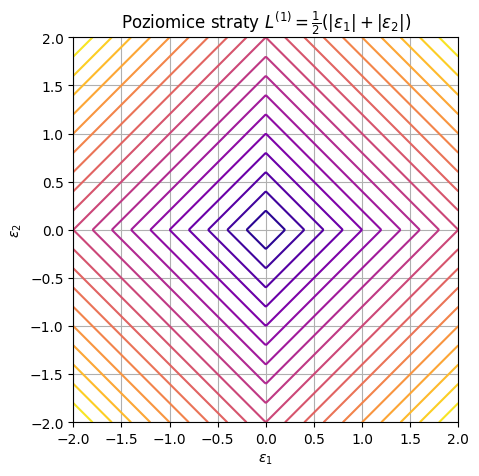

In [5]:
# Siatka wartości epsilonów
eps_range = np.linspace(-2, 2, 400)
E1, E2 = np.meshgrid(eps_range, eps_range)

# Funkcje strat
L1 = 0.5 * (np.abs(E1) + np.abs(E2))
Linf = np.maximum(np.abs(E1), np.abs(E2))

# Poziomice L1
plt.figure(figsize=(6, 5))
plt.contour(E1, E2, L1, levels=20, cmap='plasma')
plt.title("Poziomice straty $L^{(1)} = \\frac{1}{2}(|\\epsilon_1| + |\\epsilon_2|)$")
plt.xlabel("$\\epsilon_1$")
plt.ylabel("$\\epsilon_2$")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()


#### Funkcja straty $l_\infty$ - kod pochodzący z zajęć z drobnymi modyfikacjami

Using device: cuda


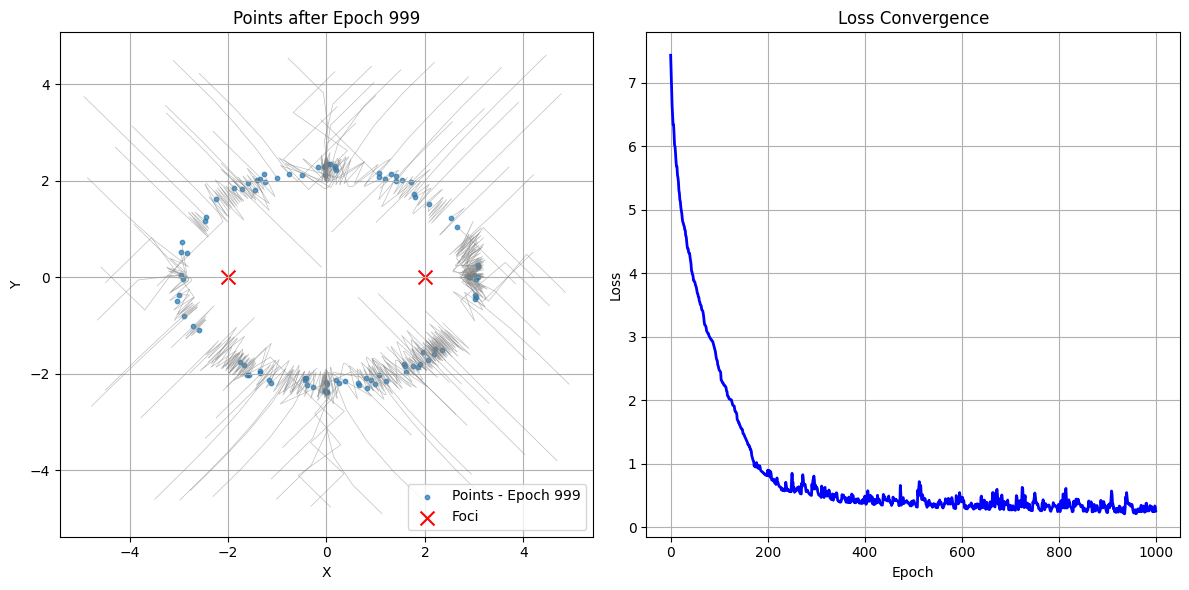

Elapsed time: 1.50 s


In [6]:
# 1) Wybór urządzenia: GPU jeśli dostępne, inaczej CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ustawienie ziarna dla powtarzalności
torch.manual_seed(42)
np.random.seed(42)

# 2) Parametry elipsy – przenosimy od razu na wybrane urządzenie
focus1 = torch.tensor([-2.0, 0.0], device=device)  # pierwsze ognisko
focus2 = torch.tensor([2.0, 0.0],  device=device)  # drugie ognisko
constant_sum = 6.0

# 3) Inicjalizacja punktów na urządzeniu
num_points = 100
points = torch.rand((num_points, 2), device=device) * 10 - 5
points.requires_grad = True

# Reset trajektorii i historii strat
trajectories = [[] for _ in range(num_points)]
loss_history = []

# 4) Definicja optymalizatora – wskazujemy, że optymalizujemy 'points' na GPU/CPU
optimizer = torch.optim.Adam([points], lr=0.1)

# Pomocnicze do mierzenia czasu
start_time = time.time()

# Parametry treningu
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # 5) Obliczenia na GPU: dystanse do ognisk
    dist1 = torch.norm(points - focus1, dim=1)
    dist2 = torch.norm(points - focus2, dim=1)
    
    loss = torch.max(torch.abs(dist1 + dist2 - constant_sum))

    loss.backward()
    optimizer.step()

    # 6) Zapis straty
    loss_history.append(loss.item())

    # 7) Przechowanie pozycji dla wizualizacji (zrzut na CPU)
    pts_cpu = points.detach().cpu().numpy()
    for i in range(num_points):
        trajectories[i].append(pts_cpu[i].copy())

# 8) Ostateczne rysowanie po zakończeniu pętli
plot_results(num_epochs - 1, trajectories, loss_history)

# Pomiar czasu
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} s")


Poniżej możemy obejrzeć animację pokazaującą jak zmienia się położenie punktów w czasie oraz jaka jest wartość funckji straty

In [7]:
url = "https://raw.githubusercontent.com/tomczj/ML24_25/main/Gradient_training/animation_linf.gif"
HTML(f"<img src='{url}' alt='Animacja L_inf loss' />")

## Analiza zbieżności dla straty $l_\infty$

W przypadku normy $\ell_\infty$ widać, że nawet po dużej liczbie epok nie uzyskujemy dobrej aproksymacji elipsy. Funkcja straty w tym przypadku określona jest jako maksimum z błędów, czyli:
 $$
  L^{(\infty)}_{\text{ellipse}} =  \max_{i} |\epsilon_i|
  $$

Tego typu funkcja również jest nieróżniczkowalna przede wszystkim w punktach, w których kilka z błędów osiąga tę samą maksymalną wartość (w $\mathbb{R}^2$ byłyby to wierzchołki kwadratu - patrz wykres poniżej). Dodatkowo, ponieważ cały gradient kierowany jest wyłącznie przez ten największy błąd, aktualizacje mogą być gwałtowne i czułe na pojedyncze punkty. W efekcie może dochodzić do "przestrzeliwania" (co jest dobrze widoczne na animacji), gdzie aktualizacja przenosi punkt w przeciwną stronę i to z dużym przemieszczeniem. To z kolei skutkuje oscylacją (lub nawet chaotycznym ruchem) funkcji straty, co tłumaczy długi czas treningu i brak zbieżności.

Poniżej pokazano również wykres przedstawiający poziomice dla tej funkcji straty - widać na niej dokładnie punkty nieróżniczkowalności.

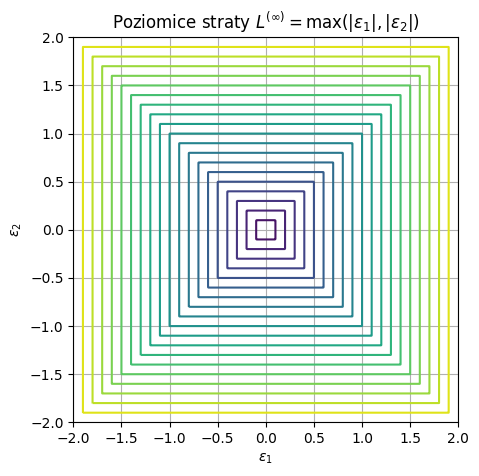

In [8]:
# Siatka wartości epsilonów
eps_range = np.linspace(-2, 2, 400)
E1, E2 = np.meshgrid(eps_range, eps_range)

# Funkcje strat
L1 = 0.5 * (np.abs(E1) + np.abs(E2))
Linf = np.maximum(np.abs(E1), np.abs(E2))

# Poziomice Linf
plt.figure(figsize=(6, 5))
plt.contour(E1, E2, Linf, levels=20, cmap='viridis')
plt.title("Poziomice straty $L^{(\\infty)} = \\max(|\\epsilon_1|, |\\epsilon_2|)$")
plt.xlabel("$\\epsilon_1$")
plt.ylabel("$\\epsilon_2$")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### Ta linijka zapobiega przypadkowemu odpaleniu animacji, które się bardzo długo liczą

In [ ]:
raise ValueError("Koniec pliku")

## Generowanie animacji 
poniższe linijki odpalają się bardzo długo ~ 2 minuty każda

### Funkcje pomocnicze

In [10]:
#rysowanie elipy do ukazania zbieżności

focus1 = torch.tensor([-2.0, 0.0])
focus2 = torch.tensor([2.0, 0.0])
constant_sum = 6.0

# Inicjalizacja punktów
num_points = 100
points = torch.rand((num_points, 2)) * 10 - 5
points.requires_grad = True

# Rysowanie elipsy
def generate_ellipse():
    t = torch.linspace(0, 2 * np.pi, 1000)
    a = constant_sum / 2
    c = torch.norm(focus1 - focus2) / 2
    b = torch.sqrt(a**2 - c**2)
    center = (focus1 + focus2) / 2
    x = a * torch.cos(t)
    y = b * torch.sin(t)
    angle = torch.atan2((focus2 - focus1)[1], (focus2 - focus1)[0])
    R = torch.tensor([[torch.cos(angle), -torch.sin(angle)],
                      [torch.sin(angle),  torch.cos(angle)]])
    ellipse = torch.stack((x, y), dim=1) @ R.T + center
    return ellipse[:, 0].numpy(), ellipse[:, 1].numpy()


#elipsa, wykorzystywana póxniej
ellipse_x, ellipse_y = generate_ellipse()

#### Funkcja straty $l_0$ - brak zakodowania, co już zostało wcześniej poruszone

#### Funkcja straty $l_1$

In [11]:
# Parametry elipsy: dwa ogniska oraz suma odległości
focus1 = torch.tensor([-2.0, 0.0])  # pierwsze ognisko
focus2 = torch.tensor([2.0, 0.0])   # drugie ognisko
constant_sum = 6.0                  # stała suma odległości

# Obliczanie półosi elipsy i konturu
c = torch.norm(focus1 - focus2) / 2            # połowa odległości między ogniskami
a = constant_sum / 2                          # półos długa
b = np.sqrt(a**2 - c.item()**2)               # półos krótka
center = (focus1.numpy() + focus2.numpy()) / 2
theta = np.linspace(0, 2 * np.pi, 200)
ellipse_x = center[0] + a * np.cos(theta)
ellipse_y = center[1] + b * np.sin(theta)

# Inicjalizacja losowych punktów do optymalizacji
num_points = 100
points = torch.rand((num_points, 2)) * 10 - 5
points.requires_grad = True

# Struktury do przechowywania tras i historii strat
trajectories = [[] for _ in range(num_points)]
loss_history = []

# Optymalizator Adam
optimizer = torch.optim.Adam([points], lr=0.1)

# Konfiguracja wykresu: animacja i wykres strat
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_xlim(-5, 5)
ax1.set_ylim(-5, 5)
ax1.set_title("Optymalizacja trajektorii punktów względem elipsy")
ax2.set_xlim(0, 1000)
ax2.set_ylim(0, 1.5)
ax2.set_title("Historia wartości funkcji straty")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Strata (L1)")

# Elementy wizualizacji na wykresach
point_scat = ax1.scatter([], [], c='blue', s=5)
traj_lines = [ax1.plot([], [], color='lightblue', linewidth=0.5, alpha=0.5)[0]
              for _ in range(num_points)]
ellipse_line, = ax1.plot(ellipse_x, ellipse_y, color='gray', linestyle='--', alpha=0.3)
foci_scat = ax1.scatter([focus1[0], focus2[0]], [focus1[1], focus2[1]],
                        color='red', marker='x', s=100)
loss_line, = ax2.plot([], [], lw=2, color='blue')

# Dane pomocnicze dla wykresu strat
epochs = []
losses = []

def update(frame):
    # Zerowanie gradientów
    optimizer.zero_grad()

    # Obliczenie odległości od ognisk
    dist1 = torch.norm(points - focus1, dim=1)
    dist2 = torch.norm(points - focus2, dim=1)
    deviation = torch.abs(dist1 + dist2 - constant_sum)

    # L1 loss: średnia odchyleń
    loss = torch.mean(deviation)
    loss.backward()
    optimizer.step()

    # Zapis i aktualizacja danych
    loss_history.append(loss.item())
    epochs.append(frame)
    losses.append(loss.item())

    with torch.no_grad():
        pts = points.detach().cpu().numpy()
        point_scat.set_offsets(pts)
        for i in range(num_points):
            trajectories[i].append(pts[i].copy())
            traj = np.array(trajectories[i])
            traj_lines[i].set_data(traj[:, 0], traj[:, 1])

    # Aktualizacja wykresu strat (w dynamiczny sposób - kamera śledzi wykres)
    loss_line.set_data(epochs, losses)
    if len(losses) > 10:
        recent = losses[-100:] if len(losses) > 100 else losses
        min_l, max_l = min(recent), max(recent)
        margin = (max_l - min_l) * 0.2
        ax2.set_ylim(min_l - margin, max_l + margin)
    else:
        ax2.set_ylim(0, 1.5)
    ax2.set_xlim(0, len(loss_history))

    return [point_scat, loss_line] + traj_lines

# Tworzenie i zapisywanie animacji
ani = animation.FuncAnimation(fig, update, frames=1000, interval=50, blit=True) #użwyamy blit, aby zmiejszyć czas generowania. Teraz dorysowaywane są elementy, które się zmieniły
ani.save("animation_l1.gif", writer="pillow", fps=20)
plt.close(fig)
HTML("<img src='animation_l1.gif' />")


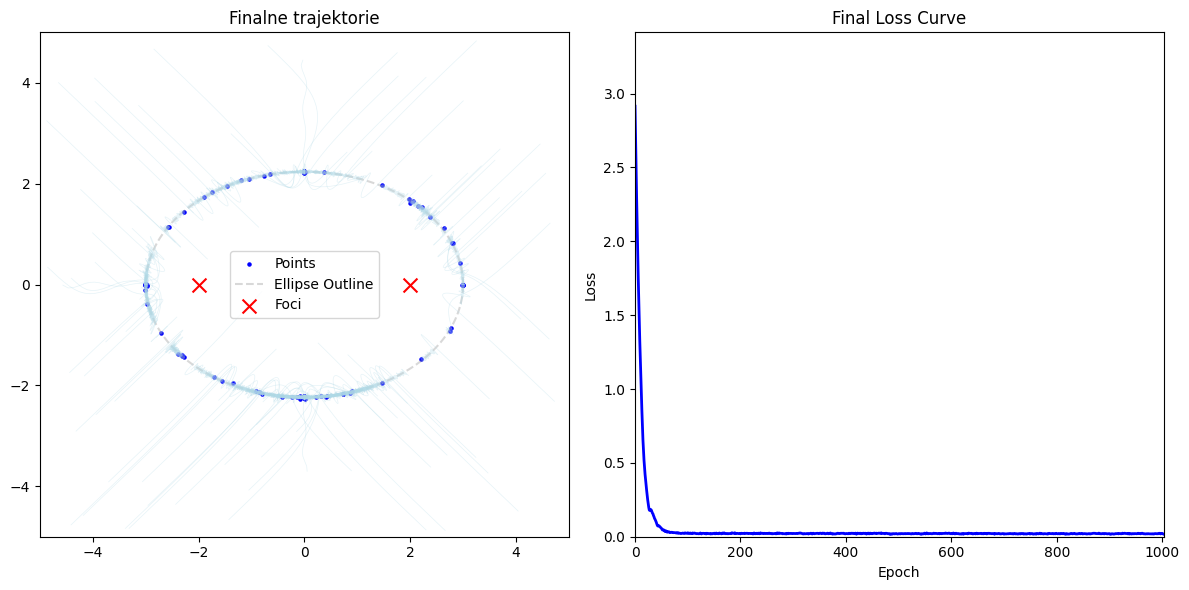

In [12]:
# Tworzymy nową figurę z dwiema osiami: jedną dla trajektorii, drugą dla wykresu straty
fig_final, (ax1f, ax2f) = plt.subplots(1, 2, figsize=(12, 6))

# Ustawiamy tytuł i granice osi
ax1f.set_title("Finalne trajektorie")
ax1f.set_xlim(-5, 5)
ax1f.set_ylim(-5, 5)

# Rysujemy końcowe pozycje punktów (po optymalizacji)
ax1f.scatter(points[:, 0].detach().cpu(),
             points[:, 1].detach().cpu(), 
             c='blue', s=5, label='Points')

# Rysujemy zarys elipsy (delikatna szara linia)
ax1f.plot(ellipse_x, ellipse_y, color='gray', linestyle='--', alpha=0.3, label='Ellipse Outline')

# Oznaczamy ogniska czerwonymi krzyżykami
ax1f.scatter([focus1[0], focus2[0]], 
             [focus1[1], focus2[1]],
             color='red', marker='x', s=100, label='Foci')

# Rysujemy pełne trajektorie ruchu każdego punktu jako cienkie, jasnoniebieskie linie
for traj in trajectories:
    traj_np = np.array(traj)
    ax1f.plot(traj_np[:, 0], traj_np[:, 1], color='lightblue', linewidth=0.5, alpha = 0.3)

# Dodajemy legendę do wykresu
ax1f.legend()


# Tytuł i etykiety osi
ax2f.set_title("Final Loss Curve")
ax2f.set_xlabel("Epoch")
ax2f.set_ylabel("Loss")

# Rysujemy funkcję straty jako niebieską linię
ax2f.plot(loss_history, lw=2, color='blue')

# Ustawiamy stały zakres osi Y (brak zoomowania)
ax2f.set_ylim(0, max(loss_history) + 0.5)

# Zakres osi X odpowiada liczbie epok
ax2f.set_xlim(0, len(loss_history))

# Automatyczne rozmieszczenie elementów wykresu
plt.tight_layout()

# Wyświetlenie finalnej figury
plt.show()


#### Funkcja straty $l_\infty$

In [13]:
#Parametry elipsy: dwa ogniska oraz suma odległości (2a)
focus1 = torch.tensor([-2.0, 0.0])  # pierwsze ognisko elipsy
focus2 = torch.tensor([2.0, 0.0])   # drugie ognisko elipsy
constant_sum = 6.0                  # stała suma odległości punktu od ognisk

#Inicjalizacja punktów do optymalizacji
num_points = 100                    # liczba punktów startowych
points = torch.rand((num_points, 2)) * 10 - 5  # losowe współrzędne w zakresie [-5,5]
points.requires_grad = True         # włączenie śledzenia gradientu

#Przygotowanie struktur do przechowywania wyników
trajectories = [[] for _ in range(num_points)]  # lista tras każdej próbki
loss_history = []                               # historia wartości funkcji strat

# Definicja optymalizatora (Adam) dla zmiennych points
optimizer = torch.optim.Adam([points], lr=0.1)

#Konfiguracja wykresu: po lewej animacja, po prawej wykres strat
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Oś animacji punktów
ax1.set_xlim(-5, 5)
ax1.set_ylim(-5, 5)
ax1.set_title("Optymalizacja trajektorii punktów względem elipsy")

# Oś wykresu strat
ax2.set_xlim(0, 1000)
ax2.set_ylim(0, constant_sum)
ax2.set_title("Historia wartości funkcji straty")
ax2.set_xlabel("Epoch")
ax2.set_ylabel(r"Loss ($L_\infty$)")

#Obiekty rysowane na wykresie animacji
point_scat  = ax1.scatter([], [], c='blue', s=5)  # punkty
traj_lines  = [ax1.plot([], [], color='lightblue', linewidth=0.5)[0]
               for _ in range(num_points)]       # ścieżki
ellipse_line, = ax1.plot(ellipse_x, ellipse_y, color='gray', linestyle='--', alpha=0.3)
foci_scat   = ax1.scatter([focus1[0], focus2[0]],
                          [focus1[1], focus2[1]],
                          color='red', marker='x', s=100)
loss_line,  = ax2.plot([], [], lw=2, color='blue') # linia strat

# Dane pomocnicze do wykresu strat
epochs = []  # numery epok
losses = []  # wartości strat

# Funkcja aktualizacji animacji, wywoływana co klatkę
def update(frame):
    # Zerowanie gradientów
    optimizer.zero_grad()

    # Obliczenie odległości każdego punktu od obu ognisk
    dist1 = torch.norm(points - focus1, dim=1)
    dist2 = torch.norm(points - focus2, dim=1)
    deviation = torch.abs(dist1 + dist2 - constant_sum)

    # L_inf loss: maksymalne odchylenie spośród wszystkich punktów
    loss = torch.max(deviation)

    # d) Backpropagation i krok optymalizatora
    loss.backward()
    optimizer.step()

    #Zapis do historii
    loss_history.append(loss.item())
    epochs.append(frame)
    losses.append(loss.item())

    # Wizualizacja nowych pozycji punktów i tras (bez śledzenia gradientów)
    with torch.no_grad():
        pts = points.detach().cpu().numpy()
        point_scat.set_offsets(pts)
        for i in range(num_points):
            trajectories[i].append(pts[i].copy())
            traj = np.array(trajectories[i])
            traj_lines[i].set_data(traj[:, 0], traj[:, 1])

    # Aktualizacja wykresu strat (w dynamiczny sposób - kamera śledzi wykres)
    loss_line.set_data(epochs, losses)
    if len(losses) > 1:
        recent = losses[-100:] if len(losses) > 100 else losses
        min_l, max_l = min(recent), max(recent)
        # jeżeli wszystkie wartości są takie same, dodaj malutkie epsilon
        if max_l == min_l:
            max_l += 1e-3
            min_l -= 1e-3
        margin = (max_l - min_l) * 0.2
        ax2.set_ylim(min_l - margin, max_l + margin)
    else:
        ax2.set_ylim(0, constant_sum)
    ax2.set_xlim(0, len(loss_history))

    # Zwracamy obiekty do przerysowania
    return [point_scat, loss_line] + traj_lines

# Tworzenie obiektu animacji
ani = animation.FuncAnimation(
    fig, update,
    frames=1000,
    interval=50,
    blit=True
)

# Zapisanie i wyświetlenie animacji
ani.save("animation_linf.gif", writer="pillow", fps=20)
plt.close(fig)
HTML("<img src='animation_linf.gif' />")


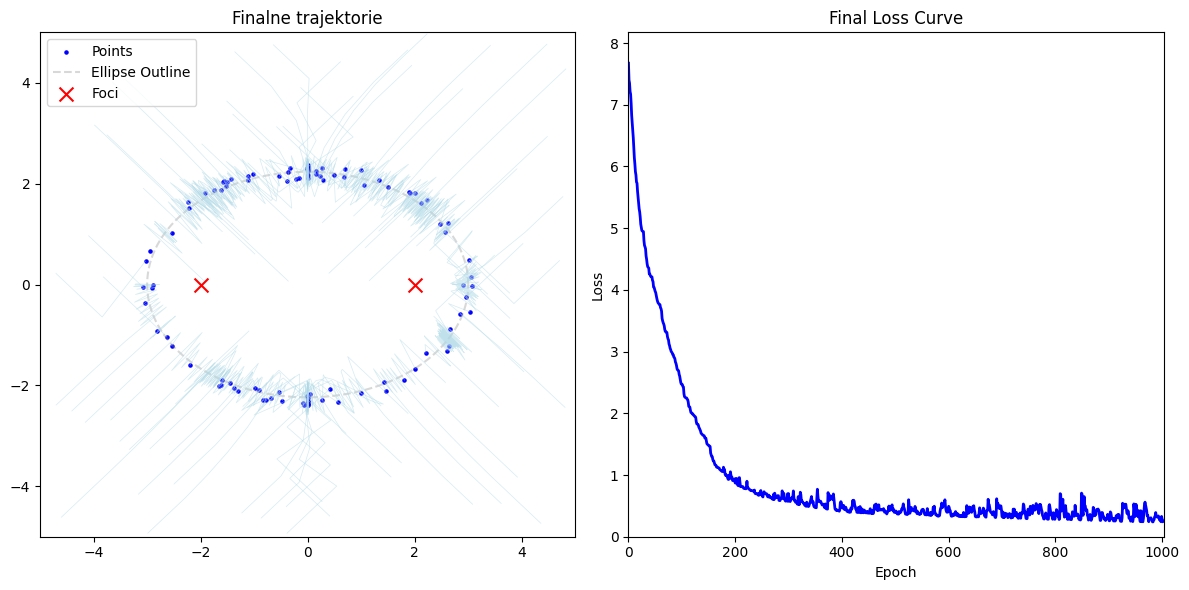

In [14]:
fig_final, (ax1f, ax2f) = plt.subplots(1, 2, figsize=(12, 6))

# Punkty końcowe i trajektorie
ax1f.set_title("Finalne trajektorie")
ax1f.set_xlim(-5, 5)
ax1f.set_ylim(-5, 5)
ax1f.scatter(points[:, 0].detach().cpu(), points[:, 1].detach().cpu(), c='blue', s=5, label='Points')
ax1f.plot(ellipse_x, ellipse_y, color='gray', linestyle='--', alpha=0.3, label='Ellipse Outline')
ax1f.scatter([focus1[0], focus2[0]], [focus1[1], focus2[1]], color='red', marker='x', s=100, label='Foci')
for traj in trajectories:
    traj_np = np.array(traj)
    ax1f.plot(traj_np[:, 0], traj_np[:, 1], color='lightblue', linewidth=0.5, alpha = 0.5)
ax1f.legend()

# Wykres straty bez zoomowania
ax2f.set_title("Final Loss Curve")
ax2f.set_xlabel("Epoch")
ax2f.set_ylabel("Loss")
ax2f.plot(loss_history, lw=2, color='blue')
ax2f.set_ylim(0, max(loss_history) + 0.5)  # Ustawienie stałego zakresu Y
ax2f.set_xlim(0, len(loss_history))

plt.tight_layout()
plt.show()